In [1]:
""" Install required dependencies"""
!pip install -q tensorflow matplotlib


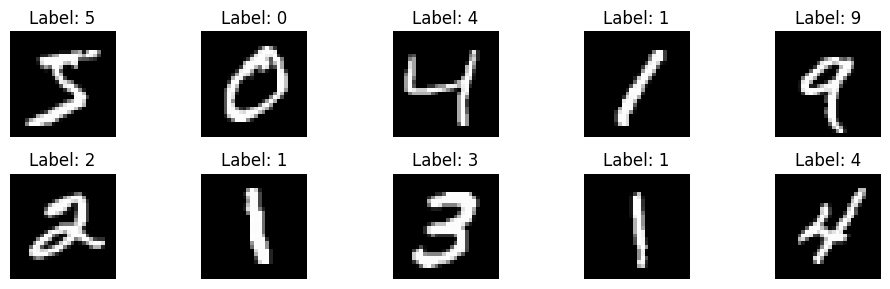

In [2]:
"""📥 Load MNIST dataset and visualize sample images"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Visualize sample digits
plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [3]:
"""🔄 Preprocess and convert grayscale to RGB, resize to 224x224 (on-the-fly using tf.data pipeline)"""

def preprocess(image, label):
    # Expand grayscale to RGB
    image = tf.stack([image] * 3, axis=-1)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 32

# Create training dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create test dataset
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [4]:
"""⚙️ Load EfficientNetB0 pretrained on ImageNet as feature extractor (without top), freeze it"""
from tensorflow.keras import layers

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg"
)
base_model.trainable = False  # freeze feature extractor

model = tf.keras.Sequential([
    base_model,
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
"""🚀 Train EfficientNetB0 (Feature Extraction Phase)"""
history = model.fit(train_ds, validation_data=test_ds, epochs=1)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5490s 3s/step - accuracy: 0.1109 - loss: 2.3036 - val_accuracy: 0.1135 - val_loss: 2.3012


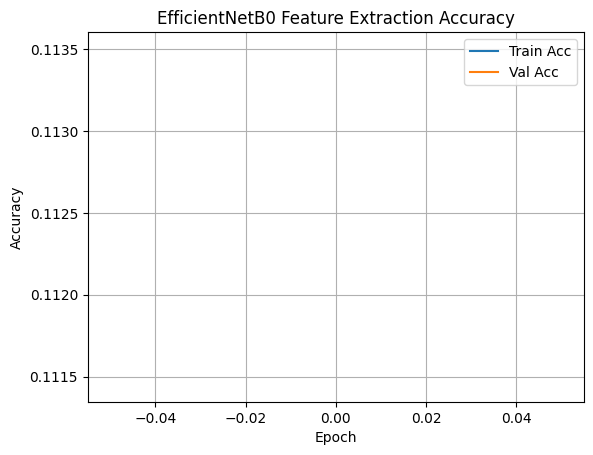

In [7]:
"""📊 Plot training and validation accuracy for feature extraction phase"""
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("EfficientNetB0 Feature Extraction Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
"""🔓 Unfreeze top EfficientNet layers for faster fine-tuning with low learning rate"""
# Only unfreeze the top N layers instead of the entire model
# EfficientNetB0 has ~236 layers; unfreezing just the top 20 is much faster
fine_tune_at = len(base_model.layers) - 20
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train for fewer epochs and with a subset of data (optional speed-up)
fine_tune_history = model.fit(
    train_ds.take(500),          # Optional: use smaller training slice (or comment this line for full)
    validation_data=test_ds.take(100),
    epochs=3                     # Fewer epochs = faster
)


Epoch 1/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 1498s 3s/step - accuracy: 0.1117 - loss: 2.3010 - val_accuracy: 0.1125 - val_loss: 2.3014
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 1450s 3s/step - accuracy: 0.1123 - loss: 2.3010 - val_accuracy: 0.1125 - val_loss: 2.3014
Epoch 3/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 1447s 3s/step - accuracy: 0.1108 - loss: 2.3010 - val_accuracy: 0.1125 - val_loss: 2.3014


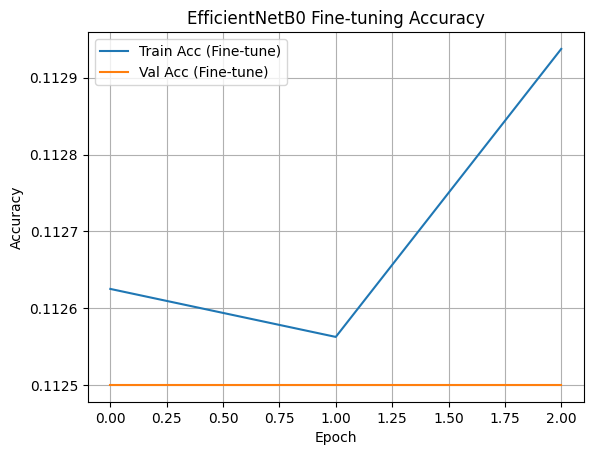

In [9]:
"""📈 Plot accuracy for fine-tuning phase"""
plt.plot(fine_tune_history.history['accuracy'], label='Train Acc (Fine-tune)')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Acc (Fine-tune)')
plt.title("EfficientNetB0 Fine-tuning Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
